In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [11]:
ks = pd.read_csv('../data/ks-projects-201801.csv', parse_dates=['deadline', 'launched'])

In [12]:
ks.head()

ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency   deadline     goal  \
0          Poetry    Publishing      GBP 2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD 2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD 2013-02-26  45000.0   
3           Music         Music      USD 2012-04-16   5000.0   
4    Film & Video  Film & Video      USD 2015-08-29  19500.0   

             launched  pledged     state  backers country  usd pledged  \
0 2015-08-11 12:12:28      0.0    failed        0      GB          0.0   
1 2017-09-02 04:43:57   2421.0    failed       15      US        100.0   
2 2013-01-12 00:20:50    220.0    failed        3      US        220.0   
3 2012-03-17 03:24:11      1.0    failed        1      US          1.0   
4 2015-07-04 08:35:03   1283.0  canceled       14      US       1283.0   

   usd_pledged_real  usd_goal_real  
0               0.0        1533.95  
1            2421.0       30000.00  
2             220.0       45000.00  
3               1.0        5000.00  
4            1283.0       19500.00

In [14]:
# Drop live projects
ks = ks.query('state !="live"')

# Add outcome column
ks = ks.assign(outcome=(ks['state'] == 'successful').astype('int'))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour, day=ks.launched.dt.day,
              month=ks.launched.dt.month, year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

# Join categorical with other data
data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

In [15]:
baseline_data.head()

goal  hour  day  month  year  outcome  category  currency  country
0   1000.0    12   11      8  2015        0       108         5        9
1  30000.0     4    2      9  2017        0        93        13       22
2  45000.0     0   12      1  2013        0        93        13       22
3   5000.0     3   17      3  2012        0        90        13       22
4  19500.0     8    4      7  2015        0        55        13       22

We can create functions that will help when testing out different encodings

In [16]:
import lightgbm as lgb
from sklearn import metrics

In [17]:
def get_data_splits(dataframe, valid_fraction=0.1):
    valid_size = int(len(dataframe) * valid_fraction)
    
    train = dataframe[:-2 * valid_size]
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]
    
    return train, valid, test

https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [18]:
def train_model(train, valid):
    feature_cols = train.columns.drop('outcome')
    
    dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])
    
    param = {'num_leaves': 64, 'objective': 'binary',
             'metric': 'auc', 'seed': 7}
    
    print('Training model!')
    
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid],
                   early_stopping_rounds=10, verbose_eval=False)
    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['outcome'], valid_pred)
    
    print('Validation AUC score: {:.4f}'.format(valid_score))
    return bst
    

In [19]:
# Train a model on the baseline data
train, valid, _ = get_data_splits(baseline_data)
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7467


### Count Encoding

Cout encoding replaces each categorical value with the number of tiems it appears in the datset. For example, if the value "GB" occured 10 times in the country feature, then each "GB" would be replaced with the number 10. In this way, categorical variables are represented by their frequency. 

The `categorical-encodings` package helps us do this, as it has `CountEncoder`.

In [28]:
import category_encoders as ce

cat_features = ['category', 'currency', 'country']
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(ks[cat_features])

data = baseline_data.join(count_encoded.add_suffix('_count'))

# Training a model on the baseline data
train, valid, test = get_data_splits(data)
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7486


A slight improvement.

If we are separting the fit from the transform, then we need to specify the columns when we initialize the `CountEncoder`, just as we do later. 

In [ ]:
import category_encoders as ce

cat_features = ['ip', 'app', 'device', 'os', 'channel']
train, valid, test = get_data_splits(clicks)

# Create the count encoder (specify the columns)
count_enc = ce.CountEncoder(cols=cat_features)

# Learn encoding from the training set
count_enc.fit(train[cat_features])

# Apply encoding to the train and validation sets as new columns
# Make sure to add `_count` as a suffix to the new columns
train_encoded = train.join(count_enc.transform(train[cat_features]).add_suffix('_count'))
valid_encoded = valid.join(count_enc.transform(valid[cat_features]).add_suffix('_count'))

# Check your answer
q_2.check()

Also, shown below is a view into how the encoder works. 

In [25]:
count_encoded.head()

category  currency  country
0      1362     33853    33393
1      5174    293624   290887
2      5174    293624   290887
3     15647    293624   290887
4     10054    293624   290887

In [27]:
count_encoded.add_suffix('_count').head()

category_count  currency_count  country_count
0            1362           33853          33393
1            5174          293624         290887
2            5174          293624         290887
3           15647          293624         290887
4           10054          293624         290887

In [29]:
data.head()

goal  hour  day  month  year  outcome  category  currency  country  \
0   1000.0    12   11      8  2015        0       108         5        9   
1  30000.0     4    2      9  2017        0        93        13       22   
2  45000.0     0   12      1  2013        0        93        13       22   
3   5000.0     3   17      3  2012        0        90        13       22   
4  19500.0     8    4      7  2015        0        55        13       22   

   category_count  currency_count  country_count  
0            1362           33853          33393  
1            5174          293624         290887  
2            5174          293624         290887  
3           15647          293624         290887  
4           10054          293624         290887

### Target encoding

Target encoding replaces a categorical value with the average of the target for that value of the feature. For example, given the country value 'CA', you'd calculate the average outcome for all the rows with `country == 'CA'`, which is about 0.28. Often, this is blended with the target probability over the entire dataset to reduce the varience of values with few occurences. 

However, it is important to make sure that the validation or test data is not included in the target encodings, which would be a form of train-test contamination. 

`TargetEncoder` is provided by the `category_encoders` package. 

In [33]:
ks.loc[ks.country == 'CA'].outcome.mean()

0.2826859956236324

In [49]:
import category_encoders as ce

cat_features = ['category', 'currency', 'country']

# Create the encoder
target_enc = ce.TargetEncoder(cols=cat_features)

train, valid, _ = get_data_splits(data)

# Fit the encoder using the categorical features and target
target_enc.fit(train[cat_features], train['outcome'])

train = train.join(target_enc.transform(train[cat_features]).add_suffix('_target'))
valid = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_target'))

In [50]:
train.head()

goal  hour  day  month  year  outcome  category  currency  country  \
0   1000.0    12   11      8  2015        0       108         5        9   
1  30000.0     4    2      9  2017        0        93        13       22   
2  45000.0     0   12      1  2013        0        93        13       22   
3   5000.0     3   17      3  2012        0        90        13       22   
4  19500.0     8    4      7  2015        0        55        13       22   

   category_count  currency_count  country_count  category_target  \
0            1362           33853          33393         0.360190   
1            5174          293624         290887         0.384615   
2            5174          293624         290887         0.384615   
3           15647          293624         290887         0.412655   
4           10054          293624         290887         0.302625   

   currency_target  country_target  
0         0.357122        0.361636  
1         0.373392        0.376631  
2         0.373392        0.376631  
3         0.373392        0.376631  
4         0.373392        0.376631

In [51]:
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7491


From 0.7467 to 0.7491

We can see the score if we only did the target encoding instead of the count encoding. The target encoder improved the score more than the count encoder did. 

The count encoder probably works well if the frequency of a categorical variable showing up is somehow important. 

In [53]:
train_nc = train.drop(columns=['category_count', 'currency_count', 'country_count'])
valid_nc = valid.drop(columns=['category_count', 'currency_count', 'country_count'])

In [54]:
bst = train_model(train_nc, valid_nc)

Training model!
Validation AUC score: 0.7483


In [56]:
train_nc.head()

goal  hour  day  month  year  outcome  category  currency  country  \
0   1000.0    12   11      8  2015        0       108         5        9   
1  30000.0     4    2      9  2017        0        93        13       22   
2  45000.0     0   12      1  2013        0        93        13       22   
3   5000.0     3   17      3  2012        0        90        13       22   
4  19500.0     8    4      7  2015        0        55        13       22   

   category_target  currency_target  country_target  
0         0.360190         0.357122        0.361636  
1         0.384615         0.373392        0.376631  
2         0.384615         0.373392        0.376631  
3         0.412655         0.373392        0.376631  
4         0.302625         0.373392        0.376631

As a sanity test, we can compare the `currency_target` entry for when the currency is 5, to confirm that it is indeed the average of the target for when the currency is 5.

In [61]:
train.loc[train.currency == 5].outcome.mean()

0.35712180384643727

### CatBoost Encoding

CatBoost encoding is similar to target encoding, however with CatBoost, for each row, the target probability is calculated only from the rows before it. 

In [66]:
cat_features = ['category', 'currency', 'country']
target_enc = ce.CatBoostEncoder(cols=cat_features)

train, valid, _ = get_data_splits(data)
target_enc.fit(train[cat_features], train['outcome'])

train = train.join(target_enc.transform(train[cat_features]).add_suffix('_cb'))
valid = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_cb'))

bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7492


CatBoost does slightly better than target encoding. 

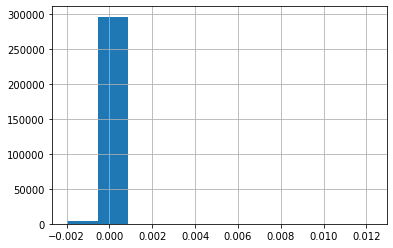

In [90]:
(train_nc.category_target - train.category_cb).hist()

#### Why is count encoding effective?

Rare values tend to have similar counts (with values like 1 or 2), so you can classify rare values together at prediction time. Common values with large counts are unlikely to have the same exact count as other values. So, the common/important values get their own grouping.

Target encoding attempts to measure the population mean of the target for each level in a categorical feature. This means when there is less data per level, the estimated mean will be further away from the "true" mean, there will be more variance. When there is little data per categorical encoding, like using IP address, it's likely that the estimates are much noisier than for the other features. The model will rely heavily on this feature since it is extremely predictive (in the training data). This causes it to make fewer splits on other features, and those features are fit on just the errors left over after accounting for IP address. So, the model will perform very poorly when seeing new IP addresses that weren't in the training data (which is likely most new data). 

### Add CatBoost encoding to dataset 

In [110]:
encoded = target_enc.transform(baseline_data[cat_features])

In [113]:
baseline_data.insert(0, 'hi', encoded['category'])

In [122]:
for col in encoded:
    baseline_data.insert(len(baseline_data.columns), col + '_cb', encoded[col])

In [123]:
assert len(baseline_data.columns) == baseline_data.shape[1]

In [124]:
baseline_data

goal  hour  day  month  year  outcome  category  currency  country  \
0        1000.0    12   11      8  2015        0       108         5        9   
1       30000.0     4    2      9  2017        0        93        13       22   
2       45000.0     0   12      1  2013        0        93        13       22   
3        5000.0     3   17      3  2012        0        90        13       22   
4       19500.0     8    4      7  2015        0        55        13       22   
...         ...   ...  ...    ...   ...      ...       ...       ...      ...   
378656  50000.0     2   17      9  2014        0        39        13       22   
378657   1500.0     3   22      6  2011        0        93        13       22   
378658  15000.0    19    1      7  2010        0        93        13       22   
378659  15000.0    18   13      1  2016        0       138        13       22   
378660   2000.0     9   19      7  2011        0        98        13       22   

        category_cb  currency_cb  country_cb  
0          0.360187     0.357122    0.361636  
1          0.384609     0.373392    0.376631  
2          0.384609     0.373392    0.376631  
3          0.412651     0.373392    0.376631  
4          0.302632     0.373392    0.376631  
...             ...          ...         ...  
378656     0.369689     0.373392    0.376631  
378657     0.384609     0.373392    0.376631  
378658     0.384609     0.373392    0.376631  
378659     0.194877     0.373392    0.376631  
378660     0.433095     0.373392    0.376631  

[375862 rows x 12 columns]